## PyTorch exercises

### Tensors

1. Make a tensor of size (2, 17)
2. Make a torch.FloatTensor of size (3, 1)
3. Make a torch.LongTensor of size (5, 2, 1)
  - fill the entire tensor with 7s
4. Make a torch.ByteTensor of size (5,)
  - fill the middle 3 indices with ones such that it records [0, 1, 1, 1, 0]
5. Perform a matrix multiplication of two tensors of size (2, 4) and (4, 2). Then do it in-place.
6. Do element-wise multiplication of two randomly filled $(n_1,n_2,n_3)$ tensors. Then store the result in an Numpy array.

### Forward-prop/backward-prop
1. Create a Tensor that `requires_grad` of size (5, 5).
2. Sum the values in the Tensor.
3. Multiply the tensor by 2 and assign the result to a new python variable (i.e. `x = result`)
4. Sum the variable's elements and assign to a new python variable
5. Print the gradients of all the variables
6. Now perform a backward pass on the last variable (NOTE: for each new python variable that you define, call `.retain_grad()`)
7. Print all gradients again

### Deep-forward NNs
1. Use dl_lab2. In Exercise 12 there, you had to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. Reimplement the manual code in PyTorch.
2. Compare test accuracy using different optimizers: SGD, Adam, Momentum.

## Implementing a deep convolutional neural network using PyTorch

### The multilayer CNN architecture

In [ ]:
from IPython.display import Image
%matplotlib inline
Image(filename='figures/14_12.png', width=800)

FileNotFoundError: [Errno 2] No such file or directory: 'figures/14_12.png'

### Loading and preprocessing the data

In [ ]:
import torch
import numpy as np
import torchvision
from torchvision import transforms
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=False,
                                           transform=transform,
                                           download=True)

Using downloaded and verified file: ./MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Using downloaded and verified file: ./MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Using downloaded and verified file: ./MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13844861.02it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
from torch.utils.data import DataLoader


batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

### Implementing a CNN using the torch.nn module

#### Configuring CNN layers in PyTorch

 * **Conv2d:** `torch.nn.Conv2d`
   * `out_channels`
   * `kernel_size`
   * `stride`
   * `padding`
   
   
 * **MaxPool2d:** `torch.nn.MaxPool2d`
   * `kernel_size`
   * `stride`
   * `padding`
   
   
 * **Dropout** `torch.nn.Dropout`
   * `p`

### Constructing a CNN in PyTorch

In [ ]:
import torch.nn as nn
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [ ]:
model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [ ]:
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))

model.add_module('fc2', nn.Linear(1024, 10))

In [ ]:
device = torch.device("cpu")
#device = torch.device("cpu")

model = model.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9786 val_accuracy: 0.9829
Epoch 2 accuracy: 0.9866 val_accuracy: 0.9881
Epoch 3 accuracy: 0.9905 val_accuracy: 0.9889
Epoch 4 accuracy: 0.9923 val_accuracy: 0.9872
Epoch 5 accuracy: 0.9944 val_accuracy: 0.9885
Epoch 6 accuracy: 0.9949 val_accuracy: 0.9897
Epoch 7 accuracy: 0.9965 val_accuracy: 0.9863
Epoch 8 accuracy: 0.9961 val_accuracy: 0.9900
Epoch 9 accuracy: 0.9967 val_accuracy: 0.9881
Epoch 10 accuracy: 0.9973 val_accuracy: 0.9867
Epoch 11 accuracy: 0.9972 val_accuracy: 0.9899
Epoch 12 accuracy: 0.9967 val_accuracy: 0.9894
Epoch 13 accuracy: 0.9978 val_accuracy: 0.9899
Epoch 14 accuracy: 0.9980 val_accuracy: 0.9878
Epoch 15 accuracy: 0.9978 val_accuracy: 0.9903
Epoch 16 accuracy: 0.9981 val_accuracy: 0.9894
Epoch 17 accuracy: 0.9979 val_accuracy: 0.9893
Epoch 18 accuracy: 0.9984 val_accuracy: 0.9911
Epoch 19 accuracy: 0.9986 val_accuracy: 0.9909
Epoch 20 accuracy: 0.9983 val_accuracy: 0.9895


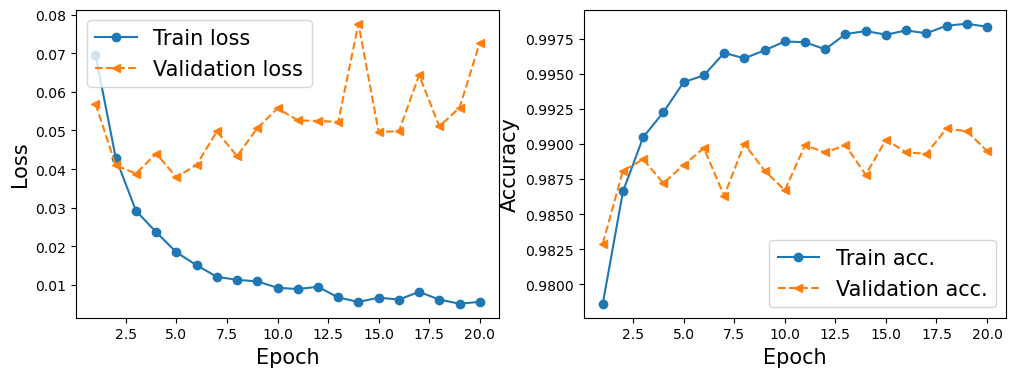

In [ ]:
import matplotlib.pyplot as plt


x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

In [ ]:
model_cpu = model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

In [ ]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)


#plt.savefig('figures/14_14.png')
plt.show()

In [ ]:
import os

if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/mnist-cnn.ph'
torch.save(model, path)


## Tensors

In [ ]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
t1 = torch.randn(2, 17)

In [ ]:
t1.shape

torch.Size([2, 17])

In [ ]:
t2 = torch.FloatTensor([1, 2, 3]).unsqueeze(1)

In [ ]:
t2.shape

torch.Size([3, 1])

In [ ]:
t3 = torch.LongTensor([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6]]).unsqueeze(2)

In [ ]:
t3.shape

torch.Size([5, 2, 1])

In [ ]:
t3.fill_(7)

tensor([[[7],
         [7]],

        [[7],
         [7]],

        [[7],
         [7]],

        [[7],
         [7]],

        [[7],
         [7]]])

In [ ]:
t4 = torch.ByteTensor([0, 0, 0, 0, 0])

In [ ]:
t4.shape

torch.Size([5])

In [ ]:
t4[1:4] = 1

In [ ]:
t4

tensor([0, 1, 1, 1, 0], dtype=torch.uint8)

In [ ]:
torch.randn(2, 4) @ torch.randn(4, 2)

tensor([[-2.8086, -0.7898],
        [-1.8713,  1.4576]])

In [ ]:
t5 = torch.randn(2, 4)

In [ ]:
t5.mm(torch.randn(4, 2))

tensor([[-0.5629,  3.4140],
        [-1.4425, -2.3703]])

In [ ]:
torch.randn(100, 55, 3) * torch.randn(100, 55, 1)

tensor([[[ 7.1365e-04, -2.0547e-03,  6.1301e-04],
         [ 1.3633e+00,  5.4420e-01,  6.4104e-01],
         [-4.2075e-01,  2.3456e+00,  6.1863e-01],
         ...,
         [-7.2727e-01,  4.1778e-01, -1.0122e-01],
         [-6.4718e-01, -1.5602e-01, -1.5610e+00],
         [-6.0216e-01, -1.2838e-03, -2.3533e-01]],

        [[-1.0132e+00,  5.5024e-01,  4.5922e-01],
         [-1.0257e+00,  4.3111e-01, -8.2103e-01],
         [-5.4086e-01,  1.2756e+00, -5.9237e-01],
         ...,
         [-7.5367e-01,  1.4431e+00, -2.3425e+00],
         [-4.2020e-01, -4.6164e-01,  2.1383e-01],
         [-3.1511e+00, -8.4765e-01,  2.2458e+00]],

        [[ 3.3612e-01, -1.2749e+00,  4.4905e-02],
         [-8.7429e-02, -2.9667e-01,  1.0060e+00],
         [-4.0965e-01, -1.9544e-01, -3.7616e-01],
         ...,
         [ 2.5283e+00,  5.0757e-01,  4.4496e-01],
         [-1.6287e+00,  6.4495e-01,  1.0433e+00],
         [-1.7725e+00, -3.4225e-02, -3.6633e-01]],

        ...,

        [[ 1.9329e+00,  7.9351e-01,  8

## Forward

In [ ]:
tf = torch.randn(5, 5, requires_grad=True)

In [ ]:
loss = tf.sum()

In [ ]:
x = tf * 2

In [ ]:
loss2 = x.sum()

In [ ]:
x.grad, tf.grad

/tmp/ipykernel_12101/1105265705.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  x.grad, tf.grad


(None, None)

In [ ]:
x.retain_grad()

In [ ]:
loss2.backward()

In [ ]:
x.grad, tf.grad

(tensor([[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]),
 tensor([[2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.]]))

## Deep

In [ ]:
class FC(torch.nn.Module):
    def __init__(self, L, units):
        super().__init__()

        self.L = L
        self.units = units

        self.layers = torch.nn.ModuleList([torch.nn.Sequential(torch.nn.LazyLinear(units),
                                                               torch.nn.LeakyReLU()) for _ in range(L-1)])
        self.final = torch.nn.Sequential(torch.nn.LazyLinear(1), torch.nn.Sigmoid())

    def forward(self, x):
        x = self.layers[0](x)

        for layer in self.layers[1:]:
            x = layer(x) + x

        x = self.final(x)
        return x

In [ ]:
model = FC(16, 128)

In [ ]:
from dnn_utils import load_data


train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [ ]:
train_x_orig.shape, train_y.shape, test_x_orig.shape, test_y.shape

((209, 64, 64, 3), (1, 209), (50, 64, 64, 3), (1, 50))

In [ ]:
class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x.reshape(x.shape[0], -1)
        self.y = y

    def __len__(self):
        return self.y.shape[1]


    def __getitem__(self, index):
        return self.x[index, :], self.y[:, index]

In [ ]:
data_train = Custom_Dataset(train_x_orig, train_y)
data_test = Custom_Dataset(test_x_orig, test_y)

In [ ]:
data_load_train = torch.utils.data.DataLoader(data_train, 16, shuffle=True, num_workers=8)
data_load_test = torch.utils.data.DataLoader(data_test, num_workers=8)

In [ ]:
next(iter(data_load_train))[0].shape

torch.Size([16, 12288])

In [ ]:
loss_f = torch.nn.BCELoss()
opti = torch.optim.SGD(model.parameters(), lr=0.0007)

In [ ]:
%%time


epochs = 100

history_train, history_test = [], []

for epoch in range(1, epochs + 1):
    model.train()
    train_total_loss = 0
    for x, y in iter(data_load_train):
        pred = model(x.to(torch.float32))

        loss = loss_f(pred, y.to(torch.float32))

        opti.zero_grad()
        loss.backward()
        opti.step()

        train_total_loss += loss.item()

    train_total_loss /= len(data_load_train)
    history_train.append(train_total_loss)

    model.eval()
    test_total_loss = 0
    for x, y in iter(data_load_test):
        with torch.inference_mode():
            pred = model(x.to(torch.float32))
            loss = loss_f(pred, y.to(torch.float32))

            test_total_loss += loss.item()

    test_total_loss /= len(data_load_test)
    history_test.append(test_total_loss)

    if epoch % 10 == 0:
        print(f"[epoch: {epoch}/{epochs}; train_loss: {train_total_loss}; test_loss: {test_total_loss}]")

[epoch: 10/100; train_loss: 61.160714285714285; test_loss: 34.0]
[epoch: 20/100; train_loss: 67.85714285714286; test_loss: 34.0]
[epoch: 30/100; train_loss: 67.85714285714286; test_loss: 34.0]
[epoch: 40/100; train_loss: 67.85714285714286; test_loss: 34.0]
[epoch: 50/100; train_loss: 61.160714285714285; test_loss: 34.0]
[epoch: 60/100; train_loss: 61.160714285714285; test_loss: 34.0]
[epoch: 70/100; train_loss: 61.160714285714285; test_loss: 34.0]
[epoch: 80/100; train_loss: 67.85714285714286; test_loss: 34.0]
[epoch: 90/100; train_loss: 67.85714285714286; test_loss: 34.0]
[epoch: 100/100; train_loss: 67.85714285714286; test_loss: 34.0]
CPU times: user 1min 12s, sys: 27 s, total: 1min 39s
Wall time: 55.3 s


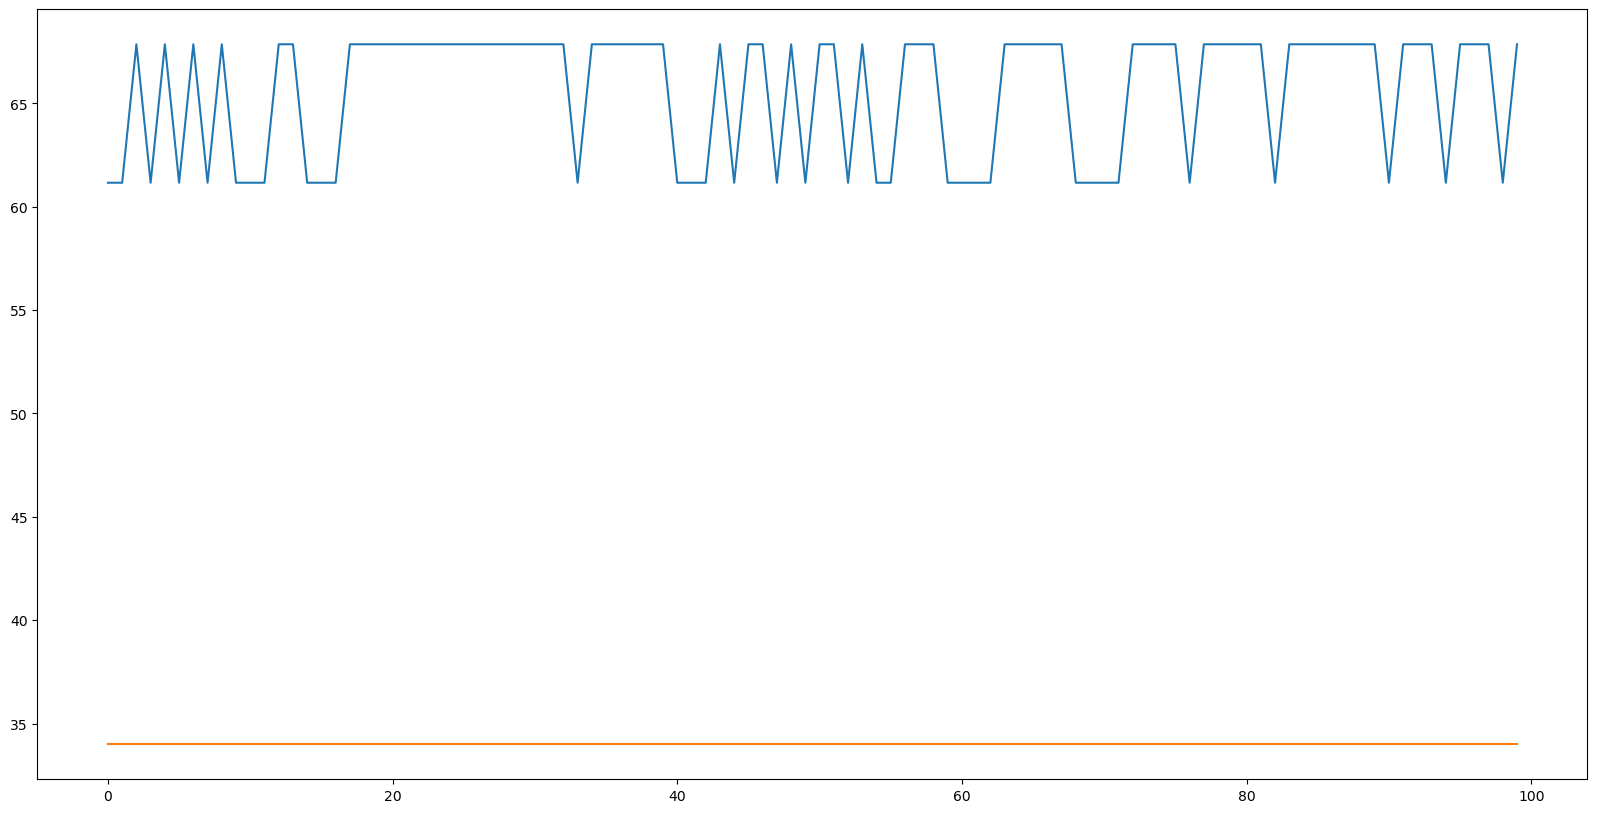

In [ ]:
plt.figure(figsize=(20, 10))

plt.plot(history_train)
plt.plot(history_test)
plt.show()

In [ ]:
model = FC(16, 128)
opti = torch.optim.SGD(model.parameters(), lr=0.0007, momentum=0.9)

In [ ]:
%%time


epochs = 100

history_train, history_test = [], []

for epoch in range(1, epochs + 1):
    model.train()
    train_total_loss = 0
    for x, y in iter(data_load_train):
        pred = model(x.to(torch.float32))

        loss = loss_f(pred, y.to(torch.float32))

        opti.zero_grad()
        loss.backward()
        opti.step()

        train_total_loss += loss.item()

    train_total_loss /= len(data_load_train)
    history_train.append(train_total_loss)

    model.eval()
    test_total_loss = 0
    for x, y in iter(data_load_test):
        with torch.inference_mode():
            pred = model(x.to(torch.float32))
            loss = loss_f(pred, y.to(torch.float32))

            test_total_loss += loss.item()

    test_total_loss /= len(data_load_test)
    history_test.append(test_total_loss)

    if epoch % 10 == 0:
        print(f"[epoch: {epoch}/{epochs}; train_loss: {train_total_loss}; test_loss: {test_total_loss}]")

[epoch: 10/100; train_loss: 32.142857142857146; test_loss: 66.0]
[epoch: 20/100; train_loss: 38.839285714285715; test_loss: 66.0]
[epoch: 30/100; train_loss: 32.142857142857146; test_loss: 66.0]
[epoch: 40/100; train_loss: 38.839285714285715; test_loss: 66.0]
[epoch: 50/100; train_loss: 32.142857142857146; test_loss: 66.0]
[epoch: 60/100; train_loss: 38.839285714285715; test_loss: 66.0]
[epoch: 70/100; train_loss: 32.142857142857146; test_loss: 66.0]
[epoch: 80/100; train_loss: 38.839285714285715; test_loss: 66.0]
[epoch: 90/100; train_loss: 38.839285714285715; test_loss: 66.0]
[epoch: 100/100; train_loss: 38.839285714285715; test_loss: 66.0]
CPU times: user 1min 30s, sys: 28.3 s, total: 1min 59s
Wall time: 1min 1s


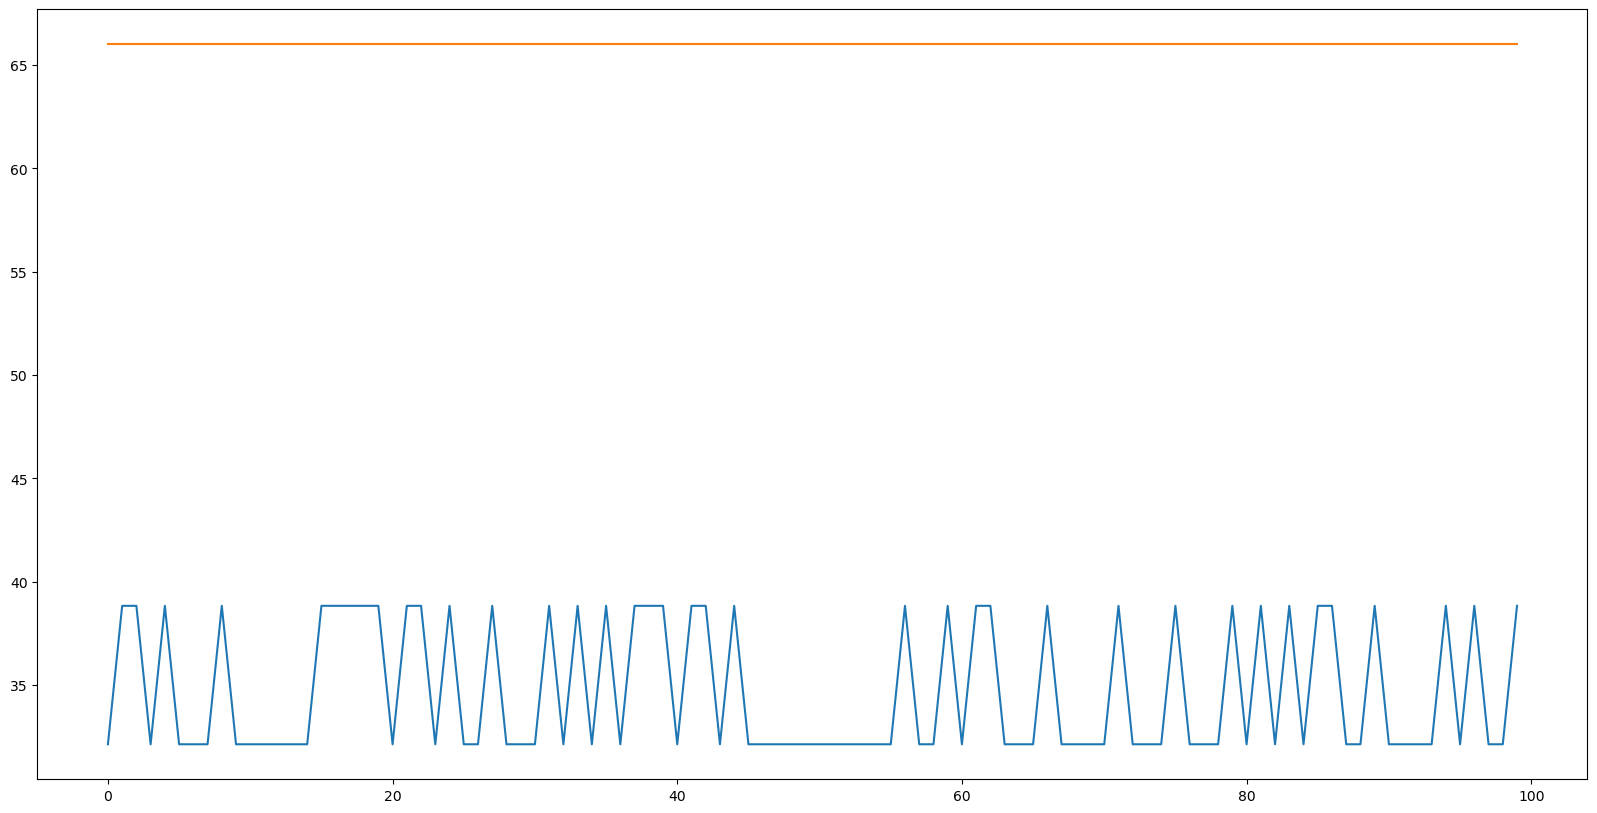

In [ ]:
plt.figure(figsize=(20, 10))

plt.plot(history_train)
plt.plot(history_test)
plt.show()

In [ ]:
model = FC(16, 128)
opti = torch.optim.Adam(model.parameters(), lr=0.0007)

In [ ]:
%%time


epochs = 100

history_train, history_test = [], []

for epoch in range(1, epochs + 1):
    model.train()
    train_total_loss = 0
    for x, y in iter(data_load_train):
        pred = model(x.to(torch.float32))

        loss = loss_f(pred, y.to(torch.float32))

        opti.zero_grad()
        loss.backward()
        opti.step()

        train_total_loss += loss.item()

    train_total_loss /= len(data_load_train)
    history_train.append(train_total_loss)

    model.eval()
    test_total_loss = 0
    for x, y in iter(data_load_test):
        with torch.inference_mode():
            pred = model(x.to(torch.float32))
            loss = loss_f(pred, y.to(torch.float32))

            test_total_loss += loss.item()

    test_total_loss /= len(data_load_test)
    history_test.append(test_total_loss)

    if epoch % 10 == 0:
        print(f"[epoch: {epoch}/{epochs}; train_loss: {train_total_loss}; test_loss: {test_total_loss}]")

[epoch: 10/100; train_loss: 32.142857142857146; test_loss: 66.0]
[epoch: 20/100; train_loss: 38.839285714285715; test_loss: 66.0]
[epoch: 30/100; train_loss: 38.839285714285715; test_loss: 66.0]
[epoch: 40/100; train_loss: 38.839285714285715; test_loss: 66.0]
[epoch: 50/100; train_loss: 32.142857142857146; test_loss: 66.0]
[epoch: 60/100; train_loss: 32.142857142857146; test_loss: 66.0]
[epoch: 70/100; train_loss: 32.142857142857146; test_loss: 66.0]
[epoch: 80/100; train_loss: 32.142857142857146; test_loss: 66.0]
[epoch: 90/100; train_loss: 32.142857142857146; test_loss: 66.0]
[epoch: 100/100; train_loss: 38.839285714285715; test_loss: 66.0]
CPU times: user 1min 53s, sys: 30.3 s, total: 2min 24s
Wall time: 1min 7s


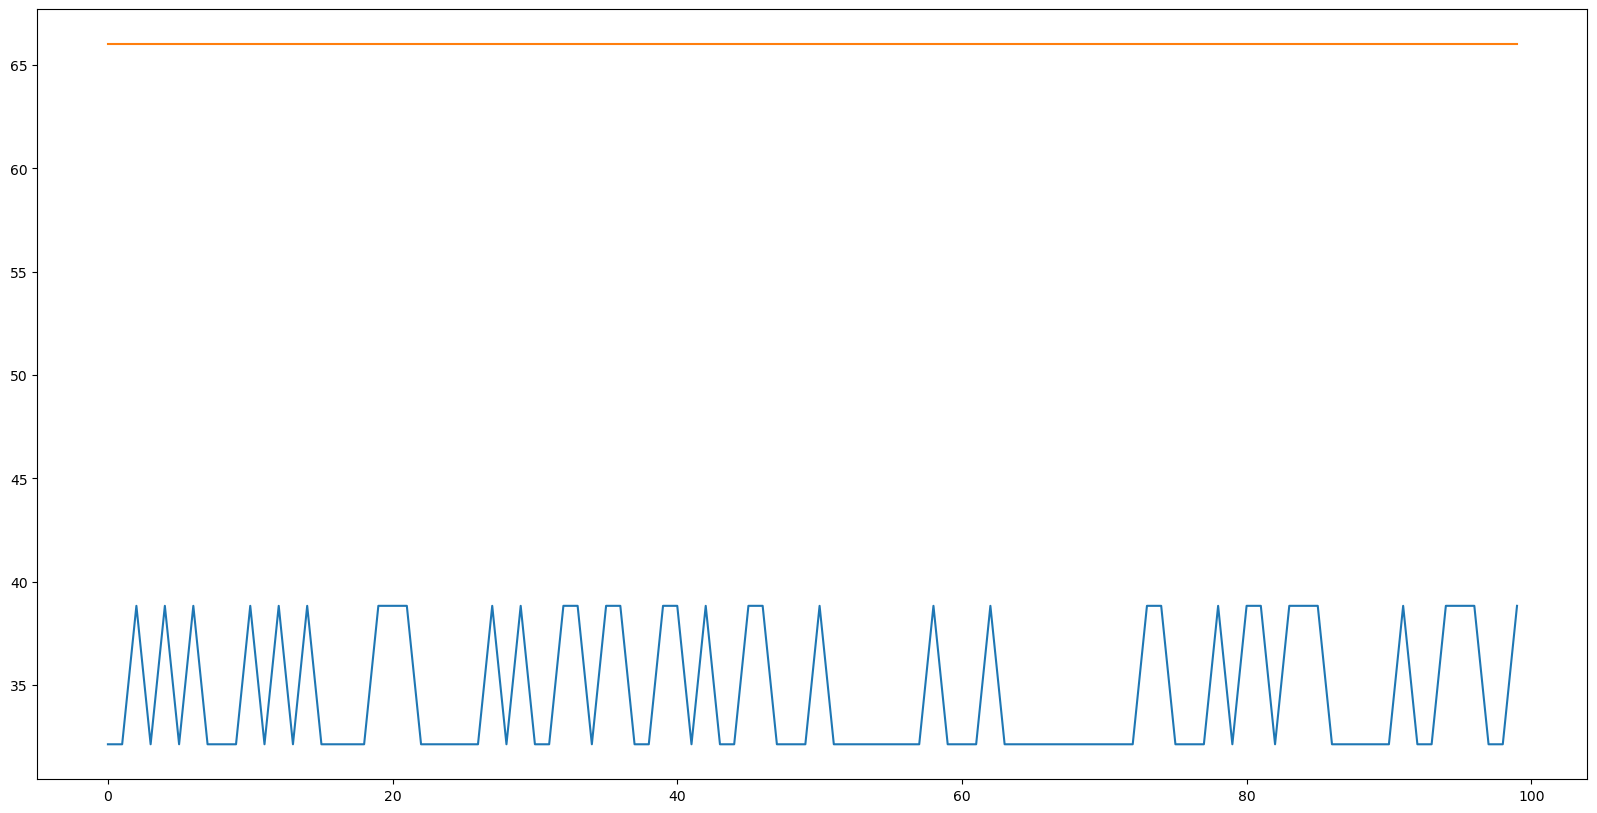

In [ ]:
plt.figure(figsize=(20, 10))

plt.plot(history_train)
plt.plot(history_test)
plt.show()